In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 656.4 kB/s eta 0:03:49
   ---------------------------------------- 0.4/150.0 MB 3.2 MB/s eta 0:00:47
   ---------------------------------------- 0.8/150.0 MB 4.7 MB/s eta 0:00:32
   ---------------------------------------- 1.2/150.0 MB 5.5 MB/s eta 0:00:28
   ---------------------------------------- 1.5/150.0 MB 5.7 MB/s eta 0:00:27
    --------------------------------------- 2.0/150.0 MB 6.5 MB/s eta 0:00:23
    --------------------------------------- 2.4/150.0 MB 6.7 MB/s eta 0:00:22
    --------------------------------------- 2.7/150.0 MB 6.7 MB/s eta 0:00:23
    --------------------------------------- 3.0/150.0 MB 6.6 MB/s eta 0:00:23
    --------------------------------------- 3.3/150.0 MB 6.5 MB/s eta 0:00:23
    -

In [4]:
df = pd.read_csv('../data/telco_cleaned1.csv')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [5]:
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

In [6]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)

Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [7]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [13]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

In [14]:
clf.fit(X_train, y_train)

C:\Users\archi\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:29:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Streamin...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [15]:
y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[901 134]
 [174 200]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1035
           1       0.60      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



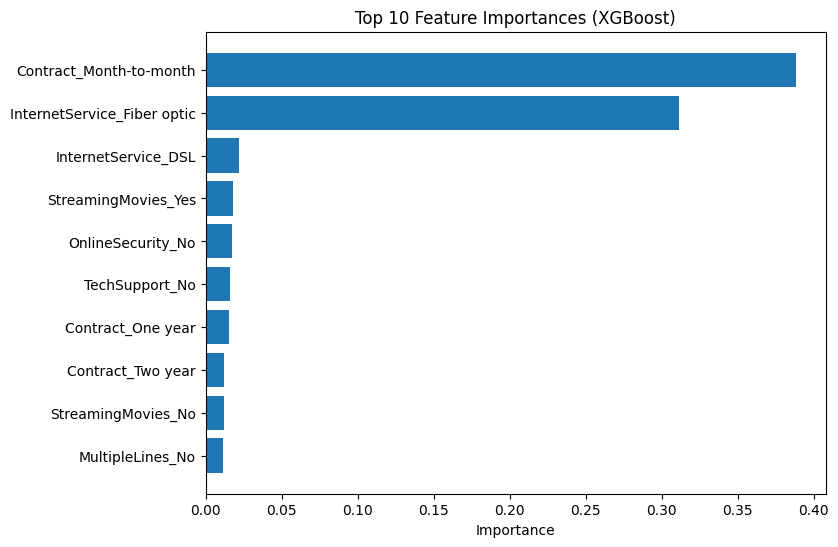

In [16]:
# Get feature names from preprocessing
feature_names = numerical_cols + \
    clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()

importances = clf.named_steps['classifier'].feature_importances_

# Plot top 10 features
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.show()